<a href="https://colab.research.google.com/github/SeifAmr1/Driver-Drowsiness-Detection/blob/main/Final_Grad_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from PIL import Image
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
drive.mount('/content/drive')

# Load and preprocess data
X, Y = [], []
open_eyes_path = '/content/drive/MyDrive/Grad_Project/Open_Eyes'
closed_eyes_path = '/content/drive/MyDrive/Grad_Project/Closed_Eyes'

for i in tqdm(glob(os.path.join(open_eyes_path, '*'))):
    temp = np.array(Image.open(i).resize((64, 64)).convert('RGB'))  # Convert directly to RGB
    X.append(temp)
    Y.append(1)

for i in tqdm(glob(os.path.join(closed_eyes_path, '*'))):
    temp = np.array(Image.open(i).resize((64, 64)).convert('RGB'))  # Convert directly to RGB
    X.append(temp)
    Y.append(0)



X = np.array(X).astype(np.float32)  # Just make sure it's float

Y = np.array(Y)

Mounted at /content/drive


100%|██████████| 2000/2000 [00:49<00:00, 40.42it/s] 


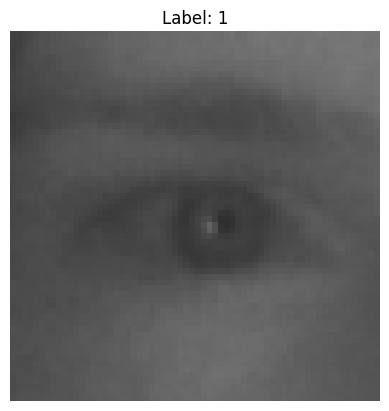

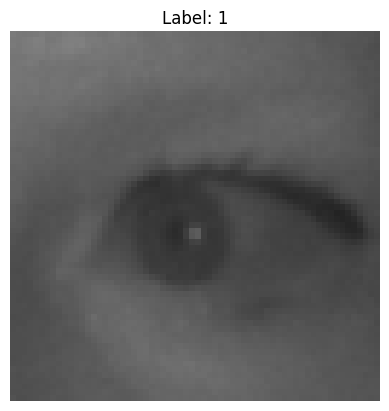

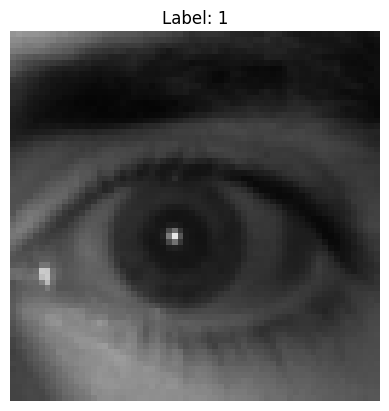

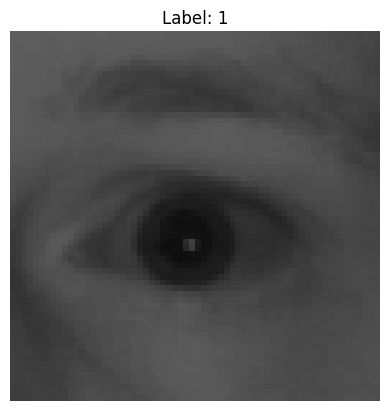

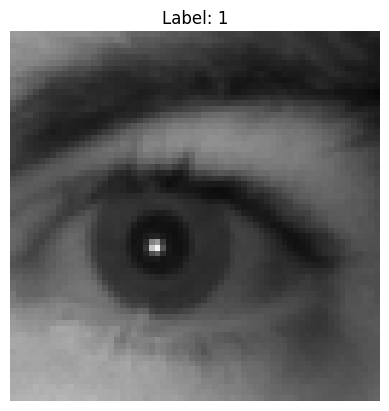

In [ ]:
import matplotlib.pyplot as plt
X = np.array(X)
Y = np.array(Y)

# Now X should have the shape (num_samples, 64, 64, 3), even if the images were originally grayscale


# Show some sample images
num_images_to_show = 5  # Number of images to display
indices = np.random.choice(len(X), num_images_to_show, replace=False)

# Plot images
for i in indices:
    plt.imshow(X[i] / 255.0)  # Normalize to [0, 1] for correct display
    plt.title(f'Label: {Y[i]}')
    plt.axis('off')
    plt.show()


In [ ]:
np.isnan(X).any(), np.isinf(X).any()  # Check for NaN or Inf


(np.False_, np.False_)

In [ ]:

# Split into train, val, test sets
x_temp, x_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Augment training images and merge with original
aug_generator = ImageDataGenerator(
    height_shift_range=0.2,
    shear_range=10,
    rotation_range=20,
    zoom_range=0.5,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

aug_iter = aug_generator.flow(x_train, y_train, batch_size=32, shuffle=False)
augmented_images, augmented_labels = [], []

num_augmented = len(x_train)
batches = num_augmented // 32 + 1

for _ in range(batches):
    batch_x, batch_y = next(aug_iter)
    augmented_images.extend(batch_x)
    augmented_labels.extend(batch_y)
    if len(augmented_images) >= num_augmented:
        break

augmented_images = np.array(augmented_images[:num_augmented])
augmented_labels = np.array(augmented_labels[:num_augmented])

# Merge datasets and normalize
x_train_augmented = np.concatenate((x_train / 255.0, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

x_val = x_val / 255.0
x_test = x_test / 255.0

# Model architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, early_stop]

# Training
history= model.fit(
    x_train_augmented, y_train_augmented,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate best model
best_model = tf.keras.models.load_model('bestModel.keras')
best_model.evaluate(x_test, y_test)

# Fine-tune
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    x_train_augmented, y_train_augmented,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# Final save
model.save('/content/drive/MyDrive/Grad_Project/finalModel_Augmented.keras')
best_model.evaluate(x_test, y_test)


/tmp/ipython-input-3-1877611504.py:39: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


Epoch 1/50
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8507 - loss: 0.3254
Epoch 1: val_loss improved from inf to 0.02650, saving model to bestModel.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.8511 - loss: 0.3247 - val_accuracy: 0.9906 - val_loss: 0.0265
Epoch 2/50
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9133 - loss: 0.2040
Epoch 2: val_loss improved from 0.02650 to 0.01480, saving model to bestModel.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9133 - loss: 0.2039 - val_accuracy: 0.9969 - val_loss: 0.0148
Epoch 3/50
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9073 - loss: 0.2009
Epoch 3: val_loss improved from 0.01480 to 0.01139, saving model to bestModel.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9076 - loss: 0.2005 - val_accuracy: 0.9969 - val_loss: 0.0114
Epoch 4/50
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9232 - loss: 0.1692
Epoch 4: val_loss did not improve from 0.01139
160/16

[0.006927345879375935, 0.9962499737739563]

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,474,181 (24.70 MB)

 Trainable params: 2,025,793 (7.73 MB)

 Non-trainable params: 396,800 (1.51 MB)

 Optimizer params: 4,051,588 (15.46 MB)

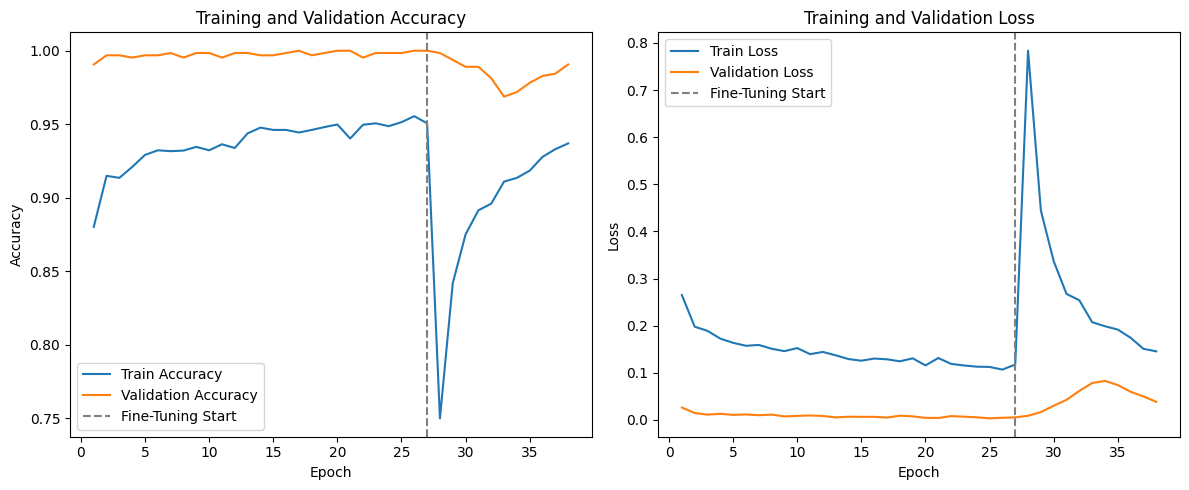

In [ ]:
import matplotlib.pyplot as plt

# Combine accuracy
combined_acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
combined_val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

# Combine loss
combined_loss = history.history['loss'] + fine_tune_history.history['loss']
combined_val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(combined_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, combined_acc, label='Train Accuracy')
plt.plot(epochs, combined_val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_loss, label='Train Loss')
plt.plot(epochs, combined_val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='gray', linestyle='--', label='Fine-Tuning Start')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


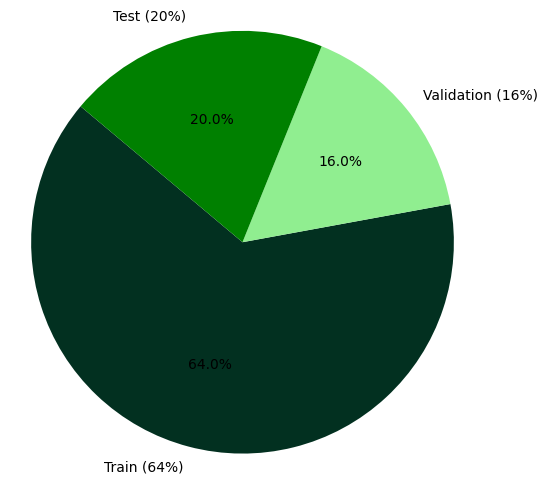

In [ ]:
import matplotlib.pyplot as plt

# Dataset split sizes
labels = ['Train (64%)', 'Validation (16%)', 'Test (20%)']
sizes = [64, 16, 20]
colors = ['#023020', '#90EE90', '#008000']

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step


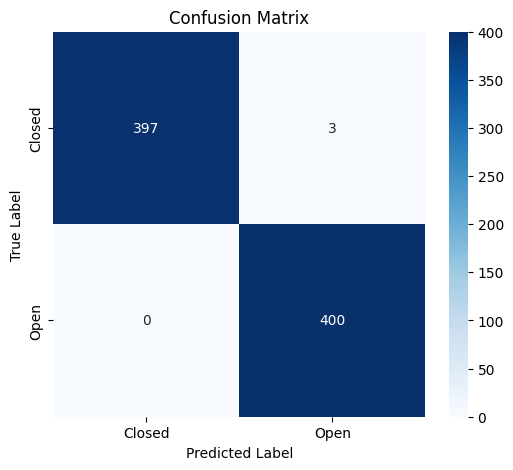

Classification Report:
              precision    recall  f1-score   support

      Closed       1.00      0.99      1.00       400
        Open       0.99      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions from the best model
y_pred_probs = best_model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary (0 or 1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Closed', 'Open']))


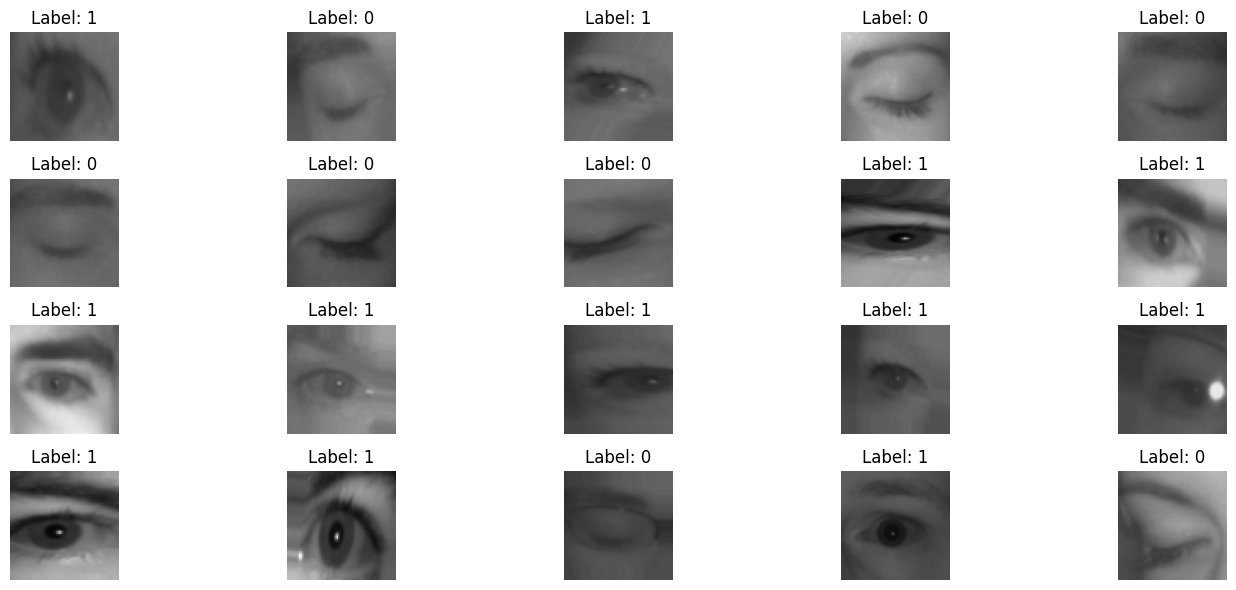

In [ ]:
import matplotlib.pyplot as plt

# Randomly select 20 indices
indices = np.random.choice(len(x_train_augmented), 20, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    img = x_train_augmented[idx]

    # Ensure proper scaling for visualization
    if img.max() > 1.0:
        img = img / 255.0

    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {int(y_train_augmented[idx])}")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from google.colab import drive
import os

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# 1. Load Your Trained Keras Model
model_path = '/content/drive/MyDrive/Grad_Project/finalModel_Augmented.keras'
model = tf.keras.models.load_model(model_path)

Mounted at /content/drive


In [ ]:
def print_class_balance(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} set class distribution:")
    for label, count in zip(unique, counts):
        print(f"{'Closed' if label == 0 else 'Open'}: {count} images")

print_class_balance(y_train, "Training")
print_class_balance(y_val, "Validation")
print_class_balance(y_test, "Test")



Training set class distribution:
Closed: 1280 images
Open: 1280 images

Validation set class distribution:
Closed: 320 images
Open: 320 images

Test set class distribution:
Closed: 400 images
Open: 400 images
